In [2]:
import pandas as pd
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.ensemble import RandomForestClassifier
import sklearn.model_selection

In [43]:
def dist(a, b):
    dst = np.zeros((len(a), len(b)))
    ind = np.zeros((len(a), len(b)))
    
    for i in range(len(a) - 1, -1, -1):
        for j in range(len(b) - 1, -1, -1):
            cur = 1e9
            
            if (i != len(a) - 1):
                cur = dst[i + 1][j]
                ind[i][j] = 0
                
            if (j != len(b) - 1 and cur > dst[i][j + 1]):
                cur = dst[i][j + 1]
                ind[i][j] = 1
                
            if (i == len(a) - 1 and j == len(b) - 1):
                cur = 0
                
            if (i != len(a) - 1 and j != len(b) - 1 and cur > dst[i + 1][j + 1]):
                cur = dst[i + 1][j + 1]
                ind[i][j] = 2
                
            cur += np.power(a[i] - b[j], 2)
            
            dst[i][j] = cur
    
    pos = []
    x = 0
    y = 0
    
    while (x != len(a) - 1 or y != len(b) - 1):
        pos.append((x, y))
        
        if (ind[x][y] == 0):
            x += 1
        elif (ind[x][y] == 1):
            y += 1
        else:
            x += 1
            y += 1
            
    pos.append((x, y))
    
    return (np.array(pos), dst[0][0])

def pol_dist(a, b):
    '''a -= np.mean(a)
    a = a / np.std(a)
    b = b * 1.
    b -= np.mean(b)
    b = b / np.std(b)'''
    pos, d = dist(a, b)

    x = a[pos[:,0]]
    y = b[pos[:,1]]
    k, e = np.polyfit(x, y, 1)
    
    return np.sum(np.power(y - k * x - e, 2))

In [4]:
f = open('data.txt')

pre = -1, -1

x = []
y = []
z = []
ans = []

x.append([])
y.append([])
z.append([])

for line in f:
    arr = line.split(',')
    
    if (len(arr) != 6):
        continue
    
    num = arr[0]
    d = arr[1]
    
    if (pre[0] == -1):
        ans.append(d)
        pre = num, d  
    
    if (pre[0] != num or pre[1] != d):
        x.append([])
        y.append([])
        z.append([])
        pre = num, d
        ans.append(d)
        
    arr[5] = arr[5].split(';')[0]    
    
    x[-1].append(arr[3])
    y[-1].append(arr[4])
    z[-1].append(arr[5])

In [5]:
from tqdm import tqdm

def conv(x):
    for i in range(len(x)):
        try:
            x[i] = float(x[i])
        except:
            x[i] = 0
    return np.array(x)

def score(A, label, c):
    ans = 0
    
    for i in range(len(A)):
        pred = np.sum(A[i] * c)
        
        ans += (pred - label[i]) ** 2
    '''
    return ans'''
    
    pred = A @ np.array([c]).T
    
    pred = pred.T[0]
    
    return np.sum((pred - label) * (pred - label))

def get_gr(A, label, c):
    c = np.array(c)
    
    pred = A @ np.array([c]).T
    pred = pred.T[0]
    
    gr = (np.array([pred - label]) * 2) @ A
    gr = gr[0]
        
    gr /= len(A)
    return gr

def auto_cor(x, p):
    c = np.zeros(p)
    
    deep = 100
    
    A = []
    label = []
    
    for i in range(len(x) - p):
        A.append(x[i: i + p])
        label.append(x[i + p])
        
    A = np.array(A)
    label = np.array(label)
    
    for it in range(deep):
        gr = -get_gr(A, label, c)
        
        alpha = 0.2
        s = 0.1
        
        beta = 0.5
        cur = score(A, label, c)
        
        while (score(A, label, c + gr * s) > cur - s * alpha * np.sum(gr * gr)):
            s *= beta
        
        c += gr * s
            
    return c

def fft_cf(x):
    return np.fft.fft(x).real[:10]

def predict(x, c):
    ans = []
    
    for i in range(len(x)):
        if (i < len(c)):
            ans.append(x[i])
        else:
            ans.append(np.sum(x[i - len(c) : i] * c))
            
    return ans

def encode(label):
    g = []
    for i in range(len(label)):
        if (label[i] == 'Walking'):
            g.append(0)
        elif (label[i] == 'Jogging'):
            g.append(1)
        elif (label[i] == 'Upstairs'):
            g.append(2)
        elif (label[i] == 'Downstairs'):
            g.append(3)
        elif (label[i] == 'Sitting'):
            g.append(4)
        else:
            g.append(5)
            
    return np.array(g)

def decode(it):
    if (it == 0):
        return 'Walking'
    elif (it == 1):
        return 'Jogging'
    elif (it == 2):
        return 'Upstairs'
    elif (it == 3):
        return 'Downstairs'
    elif (it == 4):
        return 'Sitting'
    else:
        return 'Standing'

def semor(x):
    k, b = np.polyfit(np.arange(len(x)), x, 1)
    return x - k * np.arange(len(x)) - b
    
def info(ans, y_ans, method):
    print(method, ':')
    print("Суммарное качество =", np.sum(ans == encode(y_ans)) / len(ans) * 100, '%')
    ey = encode(y_ans)
    
    for i in range(6):
        ind = ey == i
        
        print("Качество для ", decode(i), "=", np.sum(ans[ind] == ey[ind]) / np.sum(ind) * 100, '%')
        
    for i in range(6):
        ind = ey == i
        
        print("Количество людей типа", decode(i), '=', np.sum(ind))

In [6]:
c = auto_cor(conv(x[0]), 10)

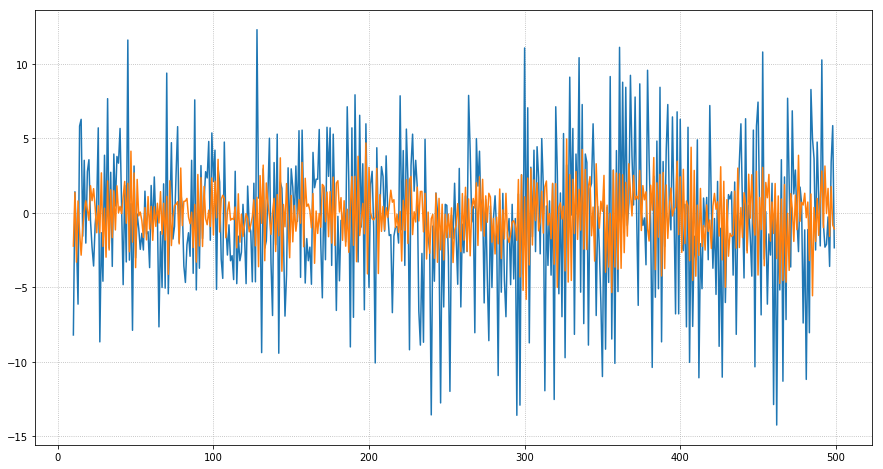

In [7]:
plt.figure(figsize=(15, 8))
plt.plot(np.arange(len(x[0]))[10:500], conv(x[0])[10:500])
plt.plot(np.arange(len(x[0]))[10:500], predict(conv(x[0]), c)[10:500])
plt.grid(ls=':')
plt.show()

In [8]:
def get_param(x):
    gr = np.linspace(np.min(x), np.max(x), 11)
    
    res = []
    
    for i in range(10):
        ind = x >= gr[i]
        res.append(np.sum(x[ind] < gr[i + 1]))
        
    return np.array(res) / len(x)

In [9]:
pt = []
y_train = []

for i in tqdm(range(len(x))):
    if (len(x[i]) < 200):
        continue
        
    x[i] = conv(x[i])
    y[i] = conv(y[i])
    z[i] = conv(z[i])
    
    for j in range(0, len(x[i]) // 200):
        #xx = semor(x[i][j * 200: (j + 1) * 200])
        #yy = semor(y[i][j * 200: (j + 1) * 200])
        #zz = semor(z[i][j * 200: (j + 1) * 200])
        
        xx = x[i][j * 200: (j + 1) * 200]
        yy = y[i][j * 200: (j + 1) * 200]
        zz = z[i][j * 200: (j + 1) * 200]
        
        pt.append(xx)
        y_train.append(ans[i])
        
X = np.array(pt)
Y = np.array(y_train)

100%|██████████| 402/402 [00:00<00:00, 509.60it/s]


In [39]:
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(X, Y, test_size=0.2)
Y_train = encode(Y_train)
Y_test = encode(Y_test)

In [46]:
numb = 0
for i in tqdm(range(10)):
    best = 1e9
    res = -1
    
    for j in range(len(X_train)):
        ps = j
        
        if (pol_dist(X_test[i], X_train[ps]) < best):
            res = Y_train[ps]  
            
    if (res == Y_test[i]):
        print("YES\n")
    else:
        print("NO\n")
            
    if (res == Y_test[i]):
        numb += 1
        
print(numb / 10)

 10%|█         | 1/10 [12:05<1:48:45, 725.02s/it]

NO



 20%|██        | 2/10 [24:11<1:36:46, 725.76s/it]

YES



KeyboardInterrupt: 

In [87]:
pt = []
y_train = []

for i in tqdm(range(len(x))):
    if (len(x[i]) < 200):
        continue
        
    x[i] = conv(x[i])
    y[i] = conv(y[i])
    z[i] = conv(z[i])
    
    for j in range(0, len(x[i]) // 200):
        #xx = semor(x[i][j * 200: (j + 1) * 200])
        #yy = semor(y[i][j * 200: (j + 1) * 200])
        #zz = semor(z[i][j * 200: (j + 1) * 200])
        
        xx = x[i][j * 200: (j + 1) * 200]
        yy = y[i][j * 200: (j + 1) * 200]
        zz = z[i][j * 200: (j + 1) * 200]
        
        pt.append(np.concatenate((auto_cor(semor(xx), 10), auto_cor(semor(yy), 10),auto_cor(semor(zz), 10), 
                                  [np.mean(xx)], [np.mean(yy)],
                                  [np.mean(zz)], [np.std(xx)], [np.std(yy)], [np.std(zz)],
                                  [np.mean(xx * xx + yy * yy + zz * zz)])))
        y_train.append(ans[i])
        
X = np.array(pt)
Y = np.array(y_train)

100%|██████████| 402/402 [2:01:21<00:00, 18.11s/it]


In [44]:
print(len(X))

5225


# МЕТОПТЫ!

In [8]:
def one_hot(y, n_classes):
    # делаем вектор из 10 координат с 0 везде кроме правильного ответа
    tmp = np.zeros(
        (len(y), n_classes), 
        dtype=np.uint8
    )
    tmp[range(len(tmp)), y] = 1
    return tmp

In [9]:
def softmax(W, b, x):
    tmp = np.exp(np.dot(x, W.T) + b)
    return (tmp.T / tmp.sum(axis=1)).T

def loss (y, pred):
    return -np.sum(y * np.log(pred), axis=1)

In [10]:
def compute_gradients(out, y, x):
    return np.hstack((np.array([np.sum(y) * out - y]).T @ np.array([x]), np.array([np.sum(y) * out - y]).T))

def gradients(W,b, x,y):
    sm = softmax(W,b,x)        
    e = [ compute_gradients(a,c,b) for a,c,b in zip(sm,y,x) ]
    return np.mean(e,axis=0).T.flatten()

In [11]:
def armijo (W, b, x, y, dW, db, alpha=0.5, beta=0.5):
    dx = -gradients(W, b, x, y)
    s = 0.01
    n = len(W)
    m = len(W[0])
    
    while (np.mean(loss(y_tr, softmax(W + s * dW, b + s * db, X_train))) > 
          np.mean(loss(y_tr, softmax(W, b, X_train))) - alpha * s * np.sum(dx ** 2)):
        s *= beta
    
    return s

In [642]:
file = open('sample', 'w')

for i in range(len(pt)):
    file.write(str(pt[i]) + ' ' + str(y_train[i]))
    file.write('\n')
    
for i in range(len(test)):
    file.write(str(test[i]) + ' ' + str(y_test[i]))
    file.write('\n')

In [20]:
file = open('output.txt', 'r')

X = []
Y = []

for line in file:
    arr = line.split(' ')
    X.append(np.array(arr[:-1], dtype=np.float))
    Y.append(arr[-1][:-1])

In [146]:
X = np.array(X)
Y = np.array(Y)
    
for i in range(len(X[0])):
    X[:, i] -= np.mean(X[:, i])
    X[:, i] /= np.std(X[:, i])
    
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(X, Y, test_size=0.2)

In [134]:
knn = KNN(n_neighbors=1, n_jobs=-1)
knn.fit(X_train, encode(Y_train))

res = knn.predict(X_test)
res = np.array(res)
info(res, Y_test, 'KNN')

KNN :
Суммарное качество = 97.79904306220095 %
Качество для  Walking = 99.53379953379954 %
Качество для  Jogging = 99.69879518072288 %
Качество для  Upstairs = 95.83333333333334 %
Качество для  Downstairs = 83.13253012048193 %
Качество для  Sitting = 96.15384615384616 %
Качество для  Standing = 100.0 %
Количество людей типа Walking = 429
Количество людей типа Jogging = 332
Количество людей типа Upstairs = 96
Количество людей типа Downstairs = 83
Количество людей типа Sitting = 52
Количество людей типа Standing = 53


In [147]:
cf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
cf.fit(X_train, encode(Y_train))

res = cf.predict(X_test)
res = np.array(res)
info(res, Y_test, 'Random Forest')

Random Forest :
Суммарное качество = 96.17224880382776 %
Качество для  Walking = 99.24050632911391 %
Качество для  Jogging = 99.44289693593315 %
Качество для  Upstairs = 89.62264150943396 %
Качество для  Downstairs = 71.60493827160494 %
Качество для  Sitting = 98.46153846153847 %
Качество для  Standing = 100.0 %
Количество людей типа Walking = 395
Количество людей типа Jogging = 359
Количество людей типа Upstairs = 106
Количество людей типа Downstairs = 81
Количество людей типа Sitting = 65
Количество людей типа Standing = 39


In [123]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split, GridSearchCV

In [57]:
#grid = {'max_depth':(range(15, 16)), 'criterion':('gini', 'entropy')}
grid = {'n_neighbors':(range(1, 15))}
cls = GridSearchCV(knn, grid, cv=5, scoring='accuracy', n_jobs=-1)
cls.fit(X_train, encode(Y_train))

GridSearchCV(cv=5, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=1, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_neighbors': range(1, 15)}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring='accuracy',
       verbose=0)

In [58]:
print(np.sum(cls.predict(X_test) == encode(Y_test)) / len(X_test))

0.8373205741626795


In [40]:
cls.cv_results_

{'mean_fit_time': array([0.00436811, 0.00858331, 0.00929232, 0.01159148, 0.0044158 ,
        0.00838871, 0.0047338 , 0.00655222, 0.00450625, 0.02479429,
        0.0121263 , 0.00933313, 0.00442472, 0.00557804]),
 'mean_score_time': array([0.16057897, 0.22001028, 0.19896479, 0.33157611, 0.24507565,
        0.35085106, 0.38490152, 0.28583841, 0.36402626, 0.32053175,
        0.31743031, 0.4424089 , 0.37992687, 0.36969981]),
 'mean_test_score': array([0.83174425, 0.81295569, 0.80370163, 0.79584969, 0.79192372,
        0.78547392, 0.78070667, 0.77790241, 0.7703309 , 0.76444195,
        0.75911385, 0.75294448, 0.75154234, 0.74312956]),
 'mean_train_score': array([1.        , 0.89862636, 0.88467483, 0.85424655, 0.84254097,
        0.8251545 , 0.81933498, 0.80776732, 0.80054744, 0.79367671,
        0.78757774, 0.78077739, 0.7767122 , 0.7697026 ]),
 'param_n_neighbors': masked_array(data=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
              mask=[False, False, False, False, False, False

In [65]:
W = np.zeros((6, 37))
b = np.zeros(6)

losses_train=[]
losses_valid=[]

y_tr = one_hot(encode(Y_train), 6)
y_te = one_hot(encode(Y_test), 6)

for i in tqdm(range(15000)):
    grad = gradients(W, b, X_train, y_tr)
    dW = -grad[:37*6].reshape((37, 6)).T
    db = -grad[37*6:]
    s = armijo(W, b, X_train, y_tr, dW, db)
    
    W += s * dW
    b += s * db
    
    losses_train.append(loss(y_tr, softmax(W, b, X_train)))
    losses_valid.append(loss(y_te, softmax(W, b, X_test)))

100%|██████████| 15000/15000 [50:27<00:00,  4.96it/s]


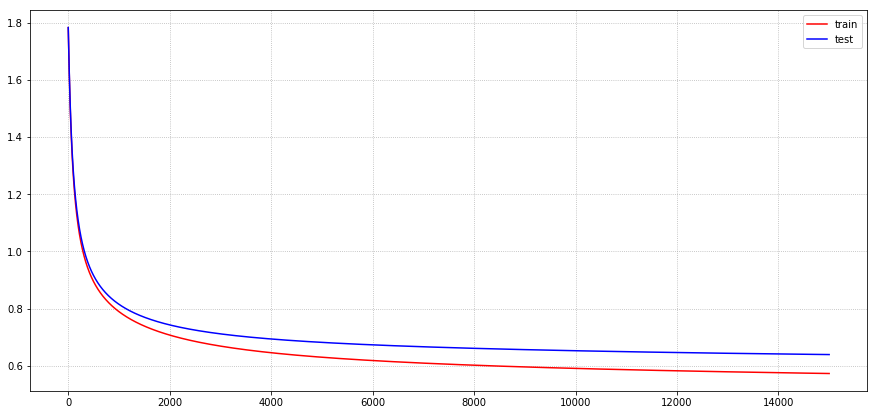

In [66]:
plt.figure(figsize=(15, 7))
plt.plot(np.arange(15000), np.mean(losses_train, axis=1), color='red', label='train')
plt.plot(np.arange(15000), np.mean(losses_valid, axis=1), color='blue', label='test')
plt.grid(ls=':')
plt.legend()
plt.show()

In [100]:
res = np.argmax(softmax(W, b, X_test), axis=1)
#print(res[:200])
#print(encode(Y_test)[:200])
res = np.array(res)
info(res, Y_test, 'Log Regression')

Log Regression :
Суммарное качество = 80.76555023923446 %
Качество для  Walking = 97.03703703703704 %
Качество для  Jogging = 93.69369369369369 %
Качество для  Upstairs = 22.0 %
Качество для  Downstairs = 16.346153846153847 %
Качество для  Sitting = 94.0 %
Качество для  Standing = 100.0 %
Количество людей типа Walking = 405
Количество людей типа Jogging = 333
Количество людей типа Upstairs = 100
Количество людей типа Downstairs = 104
Количество людей типа Sitting = 50
Количество людей типа Standing = 53
